## **Predicting Body Mass Index**

Aim:    PANDAS, NUMPY, sqlalchemy,pyodbc, PANDAS_PROFILING, SEABORN, MATPLOTLIB, SKLEARN, XGBOOST, KAGGLE

ensure font is the same on dashboard and presentation 
make dashboard legends square??? 

In [189]:
# Importing project dependencies 
import pandas as pd 
import numpy as np
from sqlalchemy import create_engine
import pyodbc
import urllib
%matplotlib inline

import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import math
from sklearn import metrics
import pickle

#### **----------------------------------  1. Data collection  -----------------------------------**

In [190]:
# Importing data through API 
!kaggle datasets download -d yasserh/bmidataset -p ..\Data --unzip 


  0%|          | 0.00/2.19k [00:00<?, ?B/s]
100%|██████████| 2.19k/2.19k [00:00<00:00, 2.24MB/s]


In [191]:
# Reading data into dataframe 
data = pd.read_csv('../Data/bmi.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [192]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


Formula: weight (kg) / [height (m)]2

In [193]:
"""
BMI	Condition 
# Below 18.5   == Underweight        ----  INDEX == 0
# 18.5-24.9    == Normal weight      ----  INDEX == 1
# 25-29.9	   == Overweight         ----  INDEX == 2
# 30-39.9      == Obese              ----  INDEX == 3 
# 40 and more  == Severely Obese     ----  INDEX == 4
"""

'\nBMI\tCondition \n# Below 18.5   == Underweight        ----  INDEX == 0\n# 18.5-24.9    == Normal weight      ----  INDEX == 1\n# 25-29.9\t   == Overweight         ----  INDEX == 2\n# 30-39.9      == Obese              ----  INDEX == 3 \n# 40 and more  == Severely Obese     ----  INDEX == 4\n'

In [194]:
# Correcting BMI Indexes (Divided by 100 as height came orignally in cm)
data['newIndex'] = data['Weight'] / (data['Height']/100)**2

In [195]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,Index,newIndex
0,Male,174,96,4,31.708284
1,Male,189,87,2,24.355421
2,Female,185,110,4,32.140248
3,Female,195,104,3,27.350427
4,Male,149,61,3,27.476240


In [196]:
# BMI conditions to correct the data index to UK(NHS) classifications
def set_bmi(row):
    if row["newIndex"] < 18.5:
        return 0
    elif row["newIndex"] >= 18.5 and  row["newIndex"] <= 24.999 :
        return 1
    elif row["newIndex"] >= 25 and  row["newIndex"] <= 29.999 :
        return 2
    elif row["newIndex"] >= 30 and  row["newIndex"] <= 39.999 :
        return 3
    else:
        return 4

# Using assign to add new column BMI based on the function conditions
data = data.assign(BMI=data.apply(set_bmi, axis=1))

# Dropping unnecessary columns
data.drop(['Index','newIndex'], axis=1, inplace=True)

In [197]:
# Viewing first 5 rows of data
data.head()

,Gender,Height,Weight,BMI
0,Male,174,96,3
1,Male,189,87,1
2,Female,185,110,3
3,Female,195,104,2
4,Male,149,61,2


In [198]:
# Viewing the data types of the columns
data.dtypes

Gender    object
Height     int64
Weight     int64
BMI        int64
dtype: object

In [199]:
# Viewing dataset shape
data.shape

(500, 4)

In [200]:
# 1st check for null values and datatype check 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   BMI     500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [201]:
# 2nd check for null values
data.isnull().sum()

Gender    0
Height    0
Weight    0
BMI       0
dtype: int64

In [202]:
# Unique count for each variable
data.nunique()

Gender      2
Height     60
Weight    110
BMI         5
dtype: int64

In [203]:
# Viewing summary of statistics for numeric columns
data.describe()

,Height,Weight,BMI
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,2.806000
std,16.375261,32.382607,1.280486
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,2.000000
50%,170.500000,106.000000,3.000000
75%,184.000000,136.000000,4.000000
max,199.000000,160.000000,4.000000


In [204]:
# (SQL standard) Formatting column headers by removing potential capital letters and spaces in column headers 
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

#### **----------------------------------  3. Data Warehousing  -----------------------------------**

In [205]:
# Saving cleaned data as csv
data.to_csv('../Data/bmi_clean.csv', index=False)

In [206]:
# def ETL_SQLServer(Server,db,tablename):
#   """
#     :param Server: Destination Server
#     :param db: Destination Database name MUST ALREADY EXIST
#     :param tablename: Project ID and Dataset name
#     """

#   # SQL table header format
#   tablename = tablename.lower()
#   tablename = tablename.replace(' ','_')

#   quoted = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=%s;DATABASE=%s"%(Server,db))
#   engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

#   data.to_sql('{tb}'.format(tb=tablename), schema='dbo', con = engine, index=False, if_exists='replace')

#   return("ETL successful, {num} rows loaded into table: {tb}.".format(num=len(data.iloc[:,0]), tb=tablename))

In [207]:
# # Function to warehouse dataframe
# ETL_SQLServer("[SERVER NAME]","Projects","P11 bmi")

#### **----------------------------------  4. Exploratory data analysis  -----------------------------------**

In [208]:
# Checking distribution of categorical fields 
print(data.gender.value_counts())
print(data.bmi.value_counts())

Female    255
Male      245
Name: gender, dtype: int64
4    203
3    130
2     68
1     65
0     34
Name: bmi, dtype: int64


In [209]:
# Viewing summary of statistics for numeric columns
data.describe()

,height,weight,bmi
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,2.806000
std,16.375261,32.382607,1.280486
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,2.000000
50%,170.500000,106.000000,3.000000
75%,184.000000,136.000000,4.000000
max,199.000000,160.000000,4.000000


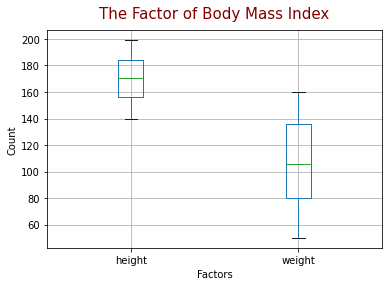

In [210]:
# Displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). 
chart = data.boxplot(column = ['height', 'weight'])
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.title('The Factor of Body Mass Index', fontsize = 15, color = 'maroon', pad = 12)
plt.xlabel('Factors')
plt.ylabel('Count')
plt.show()

In [211]:
"""
# Viewing data distribution of 'height' column
sns.boxplot(x='height', data=data, color='yellow')

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()
"""

"\n# Viewing data distribution of 'height' column\nsns.boxplot(x='height', data=data, color='yellow')\n\n# Removing the spines from the right and upper portion of the plot by default.\nsns.despine()\n"

In [212]:
"""
# Viewing data distribution of 'weight' column
sns.boxplot(x='weight', data=data, color='green')

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()
"""

"\n# Viewing data distribution of 'weight' column\nsns.boxplot(x='weight', data=data, color='green')\n\n# Removing the spines from the right and upper portion of the plot by default.\nsns.despine()\n"

C:\Users\matti\anaconda3\envs\P11\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


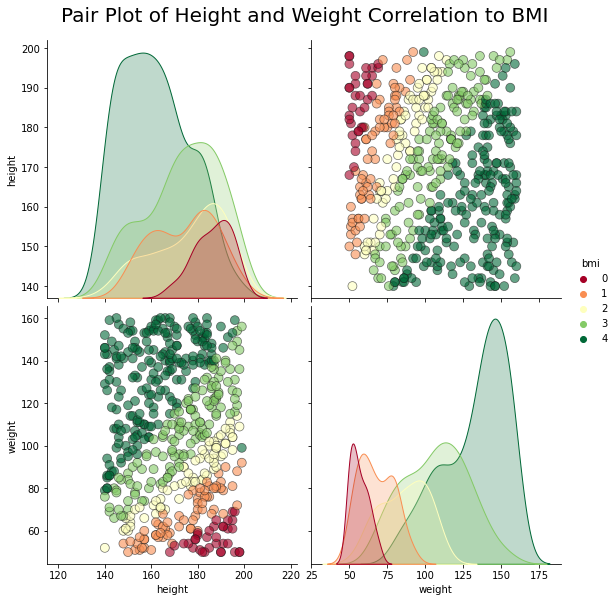

In [213]:
# PairPlot to show relationships in a dataset. *(To view list of palettes enter random value, all palettes will be shown in error message)
plot = sns.pairplot(data, vars=['height', 'weight'], 
             hue="bmi", palette='RdYlGn', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

# Setting plot title 
plt.suptitle('Pair Plot of Height and Weight Correlation to BMI', 
             size = 20, y=1.04);

# Removing the spines from the right and upper portion of the plot by default.
sns.despine()

In [214]:
pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning message

# Creating 'bmiclass' field 
data['bmiclass'] = ''

# Ouputing labelled column based on bmi of individual
data.bmiclass[data['bmi'] == 0] = 'Underweight'
data.bmiclass[data['bmi'] == 1] = 'Healthy'
data.bmiclass[data['bmi'] == 2] = 'Overweight'
data.bmiclass[data['bmi'] == 3] = 'Obese'
data.bmiclass[data['bmi'] == 4] = 'Severely obese'

In [215]:
data.head()

,gender,height,weight,bmi,bmiclass
0,Male,174,96,3,Obese
1,Male,189,87,1,Healthy
2,Female,185,110,3,Obese
3,Female,195,104,2,Overweight
4,Male,149,61,2,Overweight


In [216]:
healthy = data[data['bmiclass'] == 'Healthy']['bmi'].count() / data.shape[0] * 100
Overweight = data[data['bmiclass'] == 'Overweight']['bmi'].count() / data.shape[0] * 100
print(healthy)

13.0


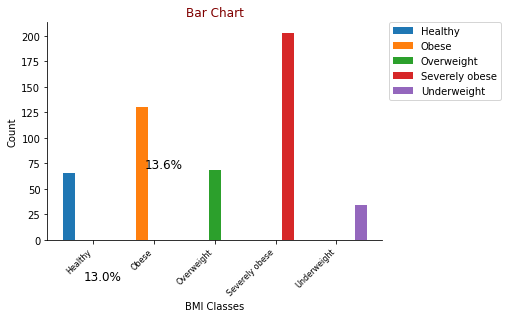

In [253]:
#visualize average of height based on index and gender
chart = data.groupby(['bmiclass', 'bmiclass'])['gender'].count().unstack().plot(kind = 'bar', width=1)
chart.set_xticklabels(chart.get_xticklabels(),rotation = (45), ha="right")
plt.title('BMI Class Distribution', fontsize = 15, pad = 12, color = 'maroon')
plt.xlabel('BMI Classes')
plt.ylabel('Count')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad = 0.)
plt.title('Bar Chart')
# plt.xticks(indexes, labels)
plt.text(-0.15, -40, f"{round(healthy, 2)}%", fontsize=12)
plt.text(0.85, 70, f"{round(Overweight, 2)}%", fontsize=12)
plt.tick_params(axis='x', which='major', labelsize=8)


# Removing the spines from the right and upper portion of the plot by default.
sns.despine()

plt.show()

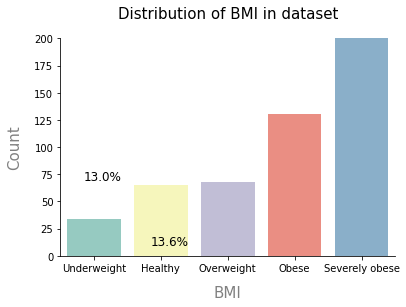

In [263]:
fig, ax = plt.subplots()
sns.countplot(x='bmi', palette="Set3", data=data)
bmiclasses = ['Underweight','Healthy','Overweight', 'Obese','Severely obese']
plt.xticks([0, 1, 2, 3, 4], bmiclasses)
plt.xlabel('BMI', size=15, labelpad=12, color='grey')
plt.ylabel('Count', size=15, labelpad=12, color='grey')
plt.title("Distribution of BMI in dataset", size=15, pad=20)
plt.ylim(0, 200)
plt.text(-0.15, 70, f"{round(healthy, 2)}%", fontsize=12)
plt.text(0.85, 10, f"{round(Overweight, 2)}%", fontsize=12)
sns.despine()
plt.show()

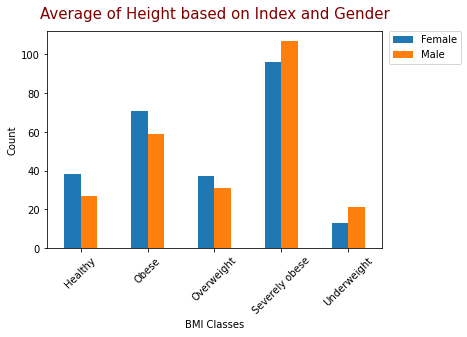

In [166]:
#visualize average of height based on index and gender
chart = data.groupby(['bmiclass', 'gender'])['gender'].count().unstack().plot(kind = 'bar')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('Average of Height based on Index and Gender', fontsize = 15, pad = 12, color = 'maroon')
plt.xlabel('BMI Classes')
plt.ylabel('Count')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad = 0.)
plt.show()

In [167]:
#correlation of each variable
data.corr()

,height,weight,bmi
height,1.000000,0.000446,-0.416359
weight,0.000446,1.000000,0.812227
bmi,-0.416359,0.812227,1.000000


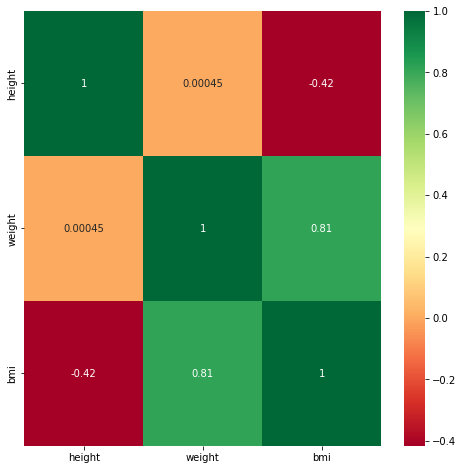

In [168]:
# Viewing correlations of each features in dataset 
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))

# Plotting heat map
plot = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [169]:
# PANDAS PROFILING

# profile report of each variable
# pandas_profiling.ProfileReport(data)

# We only use the first 100 data points
# prof = pandas_profiling.ProfileReport(data.sample(n=100)) 
# prof.to_file(output_file='output.html')

#### **----------------------------------  5. Feature Engineering  -----------------------------------**

In [170]:
data.drop(['bmiclass'], axis=1,inplace=True)

In [171]:
data.head()

,gender,height,weight,bmi
0,Male,174,96,3
1,Male,189,87,1
2,Female,185,110,3
3,Female,195,104,2
4,Male,149,61,2


In [172]:
final_data = pd.get_dummies(data, drop_first=True)

In [173]:
final_data

,height,weight,bmi,gender_Male
0,174,96,3,1
1,189,87,1,1
2,185,110,3,0
3,195,104,2,0
4,149,61,2,1
...,...,...,...,...
495,150,153,4,0
496,184,121,3,0
497,141,136,4,0
498,150,95,4,1


In [174]:
# Splitting dependent and independent features
X = final_data.drop('bmi', axis = 1)
y = final_data['bmi']

In [175]:
# Using train test split to split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# Viewing shape of train / test data
print(X_train.shape)
print(X_test.shape)

(400, 3)
(100, 3)


In [176]:
# Preparing algorithms in a list
classifiers = [
    KNeighborsClassifier(n_neighbors = 5),
    LinearSVC(),
    DecisionTreeClassifier(criterion = 'gini', max_depth = 3),
    RandomForestClassifier(random_state = 1, max_features = 'sqrt', n_jobs = 1, verbose = 1),
    XGBClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [177]:
pd.options.mode.chained_assignment = None  # Supressing SettingWithCopyWarning

#report models
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns = log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    print("=" * 30)
    print(name)
    print('****Results****')
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print("\n")
    
    log_entry = pd.DataFrame([[name, acc * 100]], columns = log_cols)
    log = log.append(log_entry)
    
print("=" * 30)

KNeighborsClassifier
****Results****
Accuracy: 93.0000%


LinearSVC
****Results****
Accuracy: 21.0000%


DecisionTreeClassifier
****Results****
Accuracy: 69.0000%


RandomForestClassifier
****Results****
Accuracy: 90.0000%


[15:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
****Results****
Accuracy: 87.0000%


AdaBoostClassifier
****Results****
Accuracy: 41.0000%


GaussianNB
****Results****
Accuracy: 68.0000%


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 95.0000%




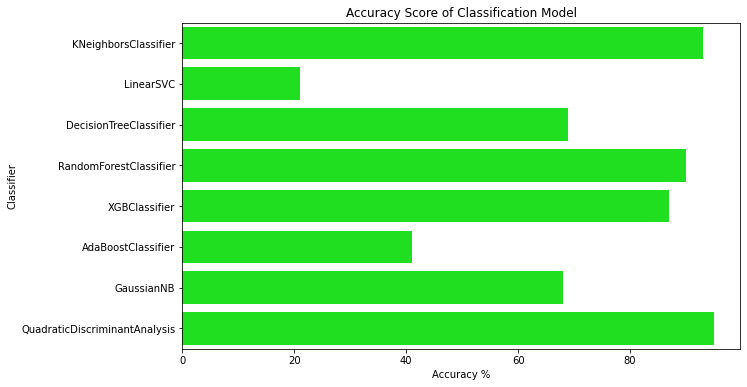

In [178]:
#visualize accuracy models
plt.figure(figsize = (10,6))
sns.set_color_codes("muted")
sns.barplot(x = 'Accuracy', y = 'Classifier', data = log, color = "lime")
plt.xlabel('Accuracy %')
plt.title('Accuracy Score of Classification Model')
plt.show()

In [179]:
#fitting model
qda = QuadraticDiscriminantAnalysis()
%time qda.fit(X_train, y_train)

Wall time: 4 ms


QuadraticDiscriminantAnalysis()

In [180]:
#prediction    
#### CHANE qda to model 
y_pred = qda.predict(X_test)
print(y_pred)

[3 1 4 3 4 3 4 2 4 2 4 2 4 2 3 3 4 4 1 1 1 4 1 0 1 3 3 4 1 4 3 1 3 3 1 3 4
 4 2 1 1 4 1 2 4 2 3 4 3 3 1 4 2 4 2 4 2 4 4 4 3 4 4 4 4 4 4 1 2 3 2 1 0 3
 4 4 4 1 4 4 3 1 3 4 3 1 3 4 3 1 4 2 4 4 2 4 2 3 4 3]


In [181]:
#check of MSE & RMSE 
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error : '+ str(mse))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : '+ str(rmse))

Mean Squared Error : 0.05
Root Mean Squared Error : 0.22360679774997896


   0   1   2   3   4
0  0   0   0   0   0
1  2  19   0   0   0
2  0   0  15   1   0
3  0   0   0  21   0
4  0   0   0   2  40


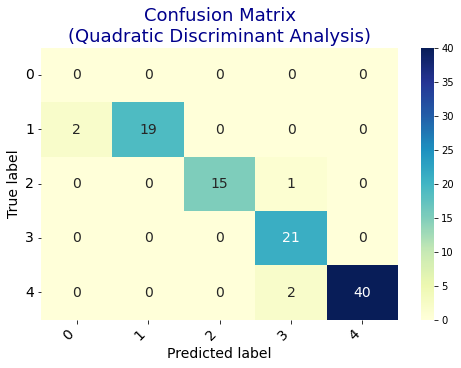

In [182]:
#confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_test, y_pred)), 
                      (0, 1, 2, 3, 4), 
                      (0, 1, 2, 3, 4))
print(matrix)

#visualize confusion matrix
plt.figure(figsize = (8,5))
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 14}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = 14)

plt.title('Confusion Matrix\n(Quadratic Discriminant Analysis)', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [183]:
#classification report
report = metrics.classification_report(y_test, y_pred)
print('Classification Report of Quadratic Discriminant Analysis : \n')
print(report)

Classification Report of Quadratic Discriminant Analysis : 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        21
           2       1.00      0.94      0.97        16
           3       0.88      1.00      0.93        21
           4       1.00      0.95      0.98        42

    accuracy                           0.95       100
   macro avg       0.78      0.76      0.77       100
weighted avg       0.97      0.95      0.96       100



C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda3\envs\P11\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\matti\anaconda3\envs\P11\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

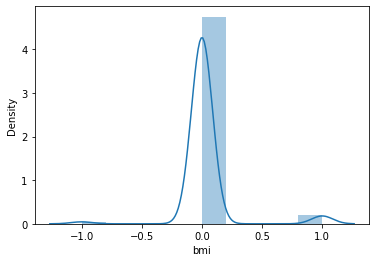

In [184]:
# Showing difference between y-test value and results from X_test
sns.distplot(y_test-y_pred)

Text(0.5, 1.0, ' Actual Prices vs Predicted Prices')

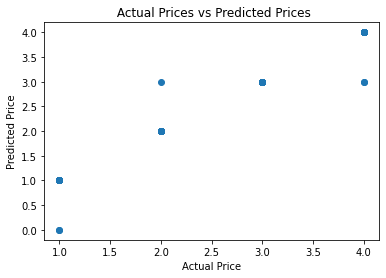

In [185]:
# Plot is linear so prediction is fairly accurate 
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(" Actual Prices vs Predicted Prices")
# plt.show()

In [186]:
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

In [187]:
# dump information to that file
pickle.dump(qda, open('quadratic_discriminant_analysis.pkl', 'wb'))